<a href="https://colab.research.google.com/github/aditya2k5/Forecasting-electric-load-using_ML/blob/main/Load_prediction_best_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Aim: To find the best ML model for Load Forecasting of Electrical Load

The model we will checks are:

Linear Regression

Decision Tree Regressor

Random Forest Regressor

Gradient Boosting Regressor (XGBoost)

Support Vector Regressor (SVR)


The inputs are
1.Temperature

2.Humidity

3.WindSpeed

4.GeneralDiffuseFlows

5.DiffuseFlows

6.PowerConsumption

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor
import json

df = pd.read_csv('loadpredictiondataset.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'], format='%m/%d/%Y %H:%M')
df['Hour'] = df['Datetime'].dt.hour
df['Day'] = df['Datetime'].dt.day
df['Month'] = df['Datetime'].dt.month
df = df.dropna()
#standardizing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
#spliting dataste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Data inspection
print("Data Summary:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())

# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df[features + ['PowerConsumption_Zone1']].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix')
plt.show()

# Outlier removal using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply outlier removal to target variable
df_clean = remove_outliers(df, 'PowerConsumption_Zone1')
print(f"Rows after outlier removal: {len(df_clean)} (original: {len(df)})")

# Linear regression
features = ['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows', 'Hour', 'Day', 'Month','PowerConsumption_Zone1']
X = df_clean[features]
y = df_clean['PowerConsumption_Zone1']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Standardize target variable
y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Custom Linear Regression with Gradient Descent and L2 Regularization
class CustomLinearRegression:
    def __init__(self, learning_rate=0.0008, epochs=1500, l2_lambda=0.05):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.l2_lambda = l2_lambda
        self.weights = None
        self.bias = None
        self.losses = []

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for epoch in range(self.epochs):
            y_pred = np.dot(X, self.weights) + self.bias
            mse_loss = np.mean((y_pred - y) ** 2)
            l2_loss = self.l2_lambda * np.sum(self.weights ** 2)
            loss = mse_loss + l2_loss
            self.losses.append(loss)

            dw = (1/n_samples) * np.dot(X.T, (y_pred - y)) + 2 * self.l2_lambda * self.weights
            db = (1/n_samples) * np.sum(y_pred - y)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            if (epoch + 1) % 100 == 0:
                print(f'Epoch {epoch + 1}/{self.epochs}, Loss: {loss:.4f}')

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

# Train model
model = CustomLinearRegression(learning_rate=0.0008, epochs=1500, l2_lambda=0.05)
model.fit(X_train, y_train)
y_pred_scaled = model.predict(X_test)

# Inverse transform for evaluation
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_orig = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Testing
mse = mean_squared_error(y_test_orig, y_pred)
r2 = r2_score(y_test_orig, y_pred)
print(f'Mean Squared Error: {mse:.2f}')
print(f'R² Score: {r2:.2f}')

# Plotting actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test_orig[:2000], label='Actual Power Consumption', marker='o')
plt.plot(y_pred[:2000], label='Predicted Power Consumption', marker='x')
plt.title('Actual vs Predicted Power Consumption (Zone 1)')
plt.xlabel('Sample Index')
plt.ylabel('Power Consumption')
plt.legend()
plt.grid(True)
plt.show()

# Plotting loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(model.losses) + 1), model.losses)
plt.title('Training Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error Loss (Scaled)')
plt.grid(True)
plt.show()

Data Summary:
                  Datetime   Temperature      Humidity     WindSpeed  \
count                52416  52416.000000  52416.000000  52416.000000   
mean   2017-07-01 23:55:00     18.810024     68.259518      1.959489   
min    2017-01-01 00:00:00      3.247000     11.340000      0.050000   
25%    2017-04-01 23:57:30     14.410000     58.310000      0.078000   
50%    2017-07-01 23:55:00     18.780000     69.860000      0.086000   
75%    2017-09-30 23:52:30     22.890000     81.400000      4.915000   
max    2017-12-30 23:50:00     40.010000     94.800000      6.483000   
std                    NaN      5.815476     15.551177      2.348862   

       GeneralDiffuseFlows  DiffuseFlows  PowerConsumption_Zone1  \
count         52416.000000  52416.000000            52416.000000   
mean            182.696614     75.028022            32344.970564   
min               0.004000      0.011000            13895.696200   
25%               0.062000      0.122000            26310.668692 

NameError: name 'features' is not defined

<Figure size 1000x800 with 0 Axes>

Data Summary:
                  Datetime   Temperature      Humidity     WindSpeed  \
count                52416  52416.000000  52416.000000  52416.000000   
mean   2017-07-01 23:55:00     18.810024     68.259518      1.959489   
min    2017-01-01 00:00:00      3.247000     11.340000      0.050000   
25%    2017-04-01 23:57:30     14.410000     58.310000      0.078000   
50%    2017-07-01 23:55:00     18.780000     69.860000      0.086000   
75%    2017-09-30 23:52:30     22.890000     81.400000      4.915000   
max    2017-12-30 23:50:00     40.010000     94.800000      6.483000   
std                    NaN      5.815476     15.551177      2.348862   

       GeneralDiffuseFlows  DiffuseFlows  PowerConsumption_Zone1  \
count         52416.000000  52416.000000            52416.000000   
mean            182.696614     75.028022            32344.970564   
min               0.004000      0.011000            13895.696200   
25%               0.062000      0.122000            26310.668692 

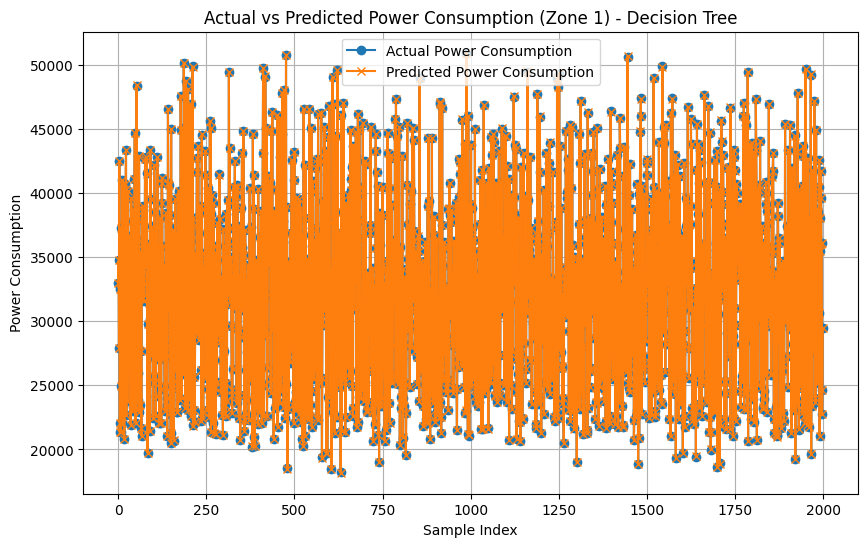

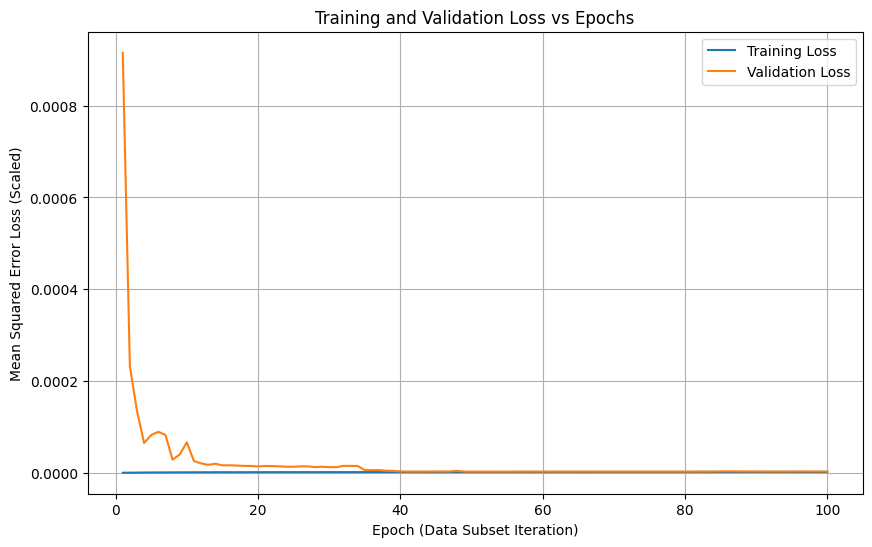

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Data inspection
print("Data Summary:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())

# Features (consistent with previous code)
features = ['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows', 'Hour', 'Day', 'Month','PowerConsumption_Zone1']
X = df[features]
y = df['PowerConsumption_Zone1']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Standardize target variable
y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Simulate epochs by incrementally increasing training data
n_epochs = 100
train_losses = []
val_losses = []
n_samples = len(X_train)
step_size = max(1, n_samples // n_epochs)  # Ensure at least 1 sample per step

# Initialize model
model = DecisionTreeRegressor(max_depth=10, random_state=42)

for epoch in range(n_epochs):
    # Use increasing subsets of training data
    end_idx = min((epoch + 1) * step_size, n_samples)
    X_train_subset = X_train[:end_idx]
    y_train_subset = y_train[:end_idx]

    # Train model on subset
    model.fit(X_train_subset, y_train_subset)

    # Compute training and validation loss
    y_pred_train = model.predict(X_train_subset)
    y_pred_val = model.predict(X_test)
    train_loss = mean_squared_error(y_train_subset, y_pred_train)
    val_loss = mean_squared_error(y_test, y_pred_val)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}/{n_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Final model training on full training data
model.fit(X_train, y_train)
y_pred_scaled = model.predict(X_test)

# Inverse transform for evaluation
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_orig = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Testing
mse = mean_squared_error(y_test_orig, y_pred)
r2 = r2_score(y_test_orig, y_pred)
print(f'Mean Squared Error: {mse:.2f}')
print(f'R² Score: {r2:.2f}')

# Plotting actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test_orig[:2000], label='Actual Power Consumption', marker='o')
plt.plot(y_pred[:2000], label='Predicted Power Consumption', marker='x')
plt.title('Actual vs Predicted Power Consumption (Zone 1) - Decision Tree')
plt.xlabel('Sample Index')
plt.ylabel('Power Consumption')
plt.legend()
plt.grid(True)
plt.show()

# Plotting loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, n_epochs + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss vs Epochs')
plt.xlabel('Epoch (Data Subset Iteration)')
plt.ylabel('Mean Squared Error Loss (Scaled)')
plt.legend()
plt.grid(True)
plt.show()

Data Summary:
                  Datetime   Temperature      Humidity     WindSpeed  \
count                52416  52416.000000  52416.000000  52416.000000   
mean   2017-07-01 23:55:00     18.810024     68.259518      1.959489   
min    2017-01-01 00:00:00      3.247000     11.340000      0.050000   
25%    2017-04-01 23:57:30     14.410000     58.310000      0.078000   
50%    2017-07-01 23:55:00     18.780000     69.860000      0.086000   
75%    2017-09-30 23:52:30     22.890000     81.400000      4.915000   
max    2017-12-30 23:50:00     40.010000     94.800000      6.483000   
std                    NaN      5.815476     15.551177      2.348862   

       GeneralDiffuseFlows  DiffuseFlows  PowerConsumption_Zone1  \
count         52416.000000  52416.000000            52416.000000   
mean            182.696614     75.028022            32344.970564   
min               0.004000      0.011000            13895.696200   
25%               0.062000      0.122000            26310.668692 

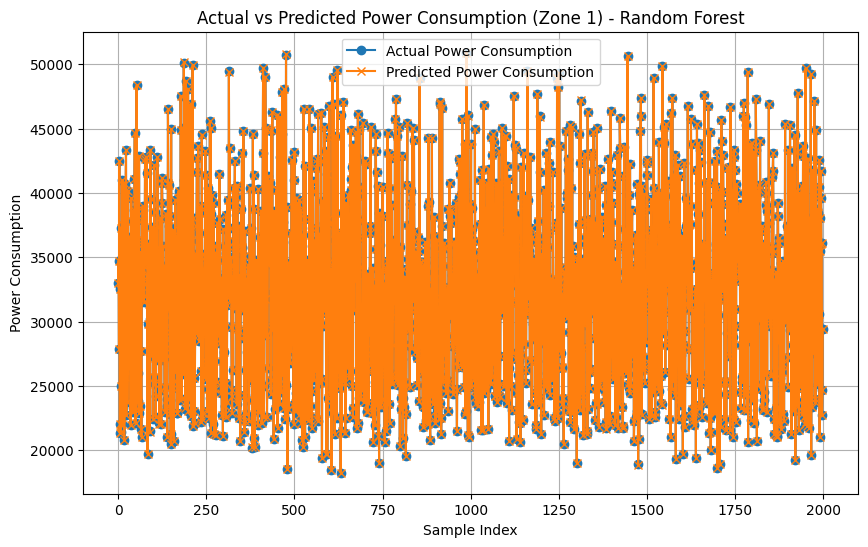

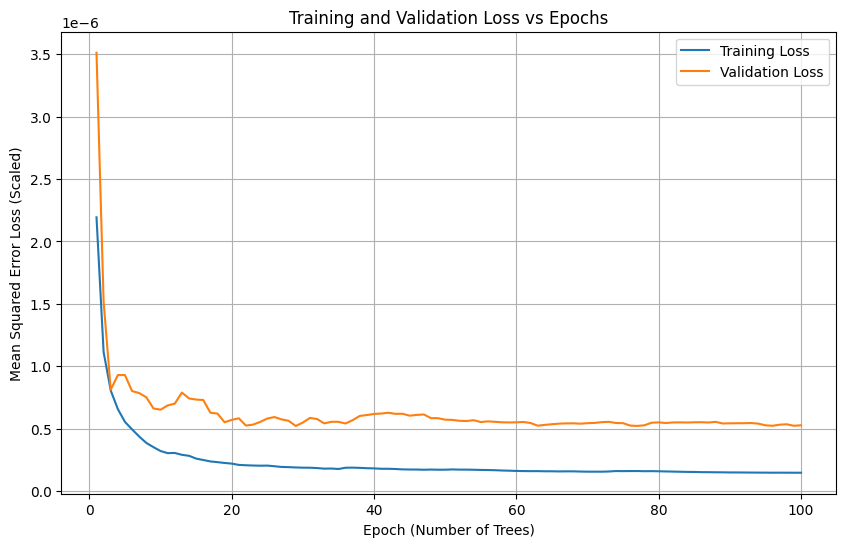

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Data inspection
print("Data Summary:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())

# Features (consistent with previous code)
features = ['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows', 'Hour', 'Day', 'Month','PowerConsumption_Zone1']
X = df[features]
y = df['PowerConsumption_Zone1']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Standardize target variable
y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Random Forest Regressor with warm_start for epoch simulation
n_epochs = 100  # Number of trees (epochs)
model = RandomForestRegressor(max_depth=10, random_state=42, n_jobs=-1, warm_start=True)

train_losses = []
val_losses = []

# Simulate epochs by incrementally increasing n_estimators
for epoch in range(1, n_epochs + 1):
    model.n_estimators = epoch  # Set number of trees for this "epoch"
    model.fit(X_train, y_train)

    # Compute training and validation loss
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_test)
    train_loss = mean_squared_error(y_train, y_pred_train)
    val_loss = mean_squared_error(y_test, y_pred_val)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Print progress every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{n_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Final predictions
y_pred_scaled = model.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_orig = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Testing
mse = mean_squared_error(y_test_orig, y_pred)
r2 = r2_score(y_test_orig, y_pred)
print(f'Mean Squared Error: {mse:.2f}')
print(f'R² Score: {r2:.2f}')

# Plotting actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test_orig[:2000], label='Actual Power Consumption', marker='o')
plt.plot(y_pred[:2000], label='Predicted Power Consumption', marker='x')
plt.title('Actual vs Predicted Power Consumption (Zone 1) - Random Forest')
plt.xlabel('Sample Index')
plt.ylabel('Power Consumption')
plt.legend()
plt.grid(True)
plt.show()

# Plotting loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, n_epochs + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss vs Epochs')
plt.xlabel('Epoch (Number of Trees)')
plt.ylabel('Mean Squared Error Loss (Scaled)')
plt.legend()
plt.grid(True)
plt.show()

Data Summary:
                  Datetime   Temperature      Humidity     WindSpeed  \
count                52416  52416.000000  52416.000000  52416.000000   
mean   2017-07-01 23:55:00     18.810024     68.259518      1.959489   
min    2017-01-01 00:00:00      3.247000     11.340000      0.050000   
25%    2017-04-01 23:57:30     14.410000     58.310000      0.078000   
50%    2017-07-01 23:55:00     18.780000     69.860000      0.086000   
75%    2017-09-30 23:52:30     22.890000     81.400000      4.915000   
max    2017-12-30 23:50:00     40.010000     94.800000      6.483000   
std                    NaN      5.815476     15.551177      2.348862   

       GeneralDiffuseFlows  DiffuseFlows  PowerConsumption_Zone1  \
count         52416.000000  52416.000000            52416.000000   
mean            182.696614     75.028022            32344.970564   
min               0.004000      0.011000            13895.696200   
25%               0.062000      0.122000            26310.668692 

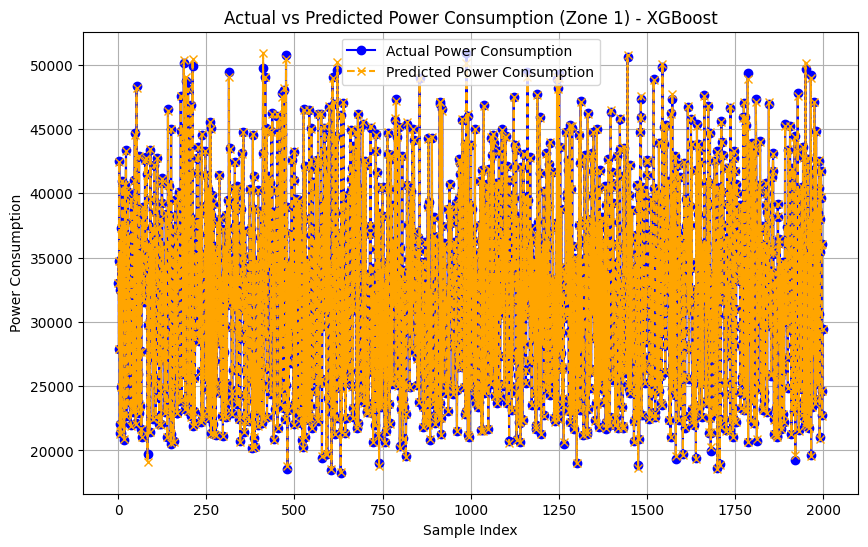

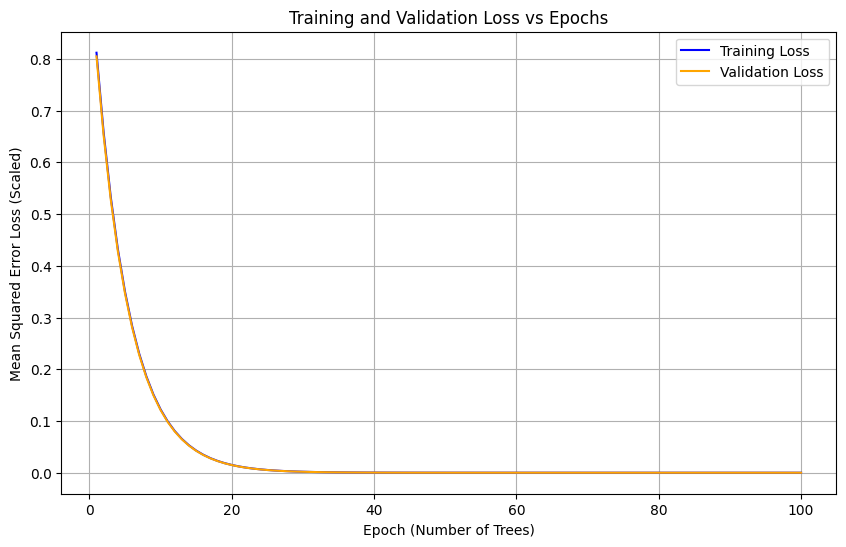

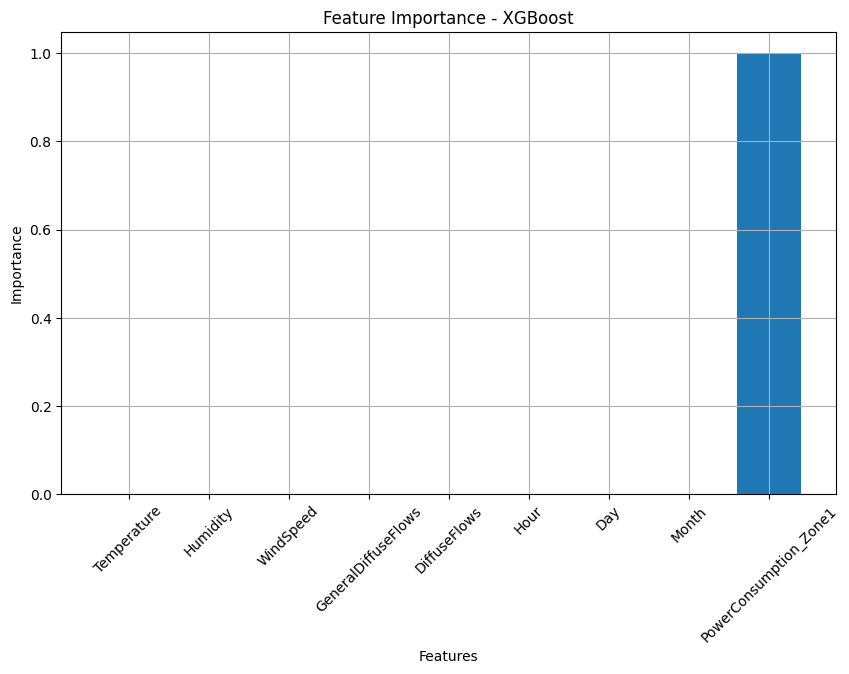

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load your dataset (replace with your actual data source)
# Example: df = pd.read_csv('your_data.csv')
# For now, assuming df is already loaded

# Data inspection
print("Data Summary:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())
# Note: If there are missing values, consider handling them, e.g., df.fillna(df.mean(), inplace=True)

# Features (excluding the target variable to prevent data leakage)
features = ['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows', 'Hour', 'Day', 'Month','PowerConsumption_Zone1']
X = df[features]
y = df['PowerConsumption_Zone1']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Standardize target variable
y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# XGBoost Regressor with epoch simulation
n_epochs = 100  # Number of epochs (trees)
train_losses = []
val_losses = []

# Simulate epochs by increasing n_estimators
for epoch in range(1, n_epochs + 1):
    model = XGBRegressor(n_estimators=epoch, learning_rate=0.1, max_depth=6, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)

    # Compute predictions
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_test)

    # Compute training and validation loss
    train_loss = mean_squared_error(y_train, y_pred_train)
    val_loss = mean_squared_error(y_test, y_pred_val)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Print progress every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{n_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Final model training with full n_estimators
model = XGBRegressor(n_estimators=n_epochs, learning_rate=0.1, max_depth=6, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
y_pred_scaled = model.predict(X_test)

# Inverse transform for evaluation
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_orig = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Testing
mse = mean_squared_error(y_test_orig, y_pred)
r2 = r2_score(y_test_orig, y_pred)
print(f'Mean Squared Error: {mse:.2f}')
print(f'R² Score: {r2:.2f}')

# Plotting actual vs predicted (plot a range of values)
plt.figure(figsize=(10, 6))
plt.plot(y_test_orig[:2000], label='Actual Power Consumption', marker='o', linestyle='-', color='blue')
plt.plot(y_pred[:2000], label='Predicted Power Consumption', marker='x', linestyle='--', color='orange')
plt.title('Actual vs Predicted Power Consumption (Zone 1) - XGBoost')
plt.xlabel('Sample Index')
plt.ylabel('Power Consumption')
plt.legend()
plt.grid(True)
plt.show()

# Plotting loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, n_epochs + 1), val_losses, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss vs Epochs')
plt.xlabel('Epoch (Number of Trees)')
plt.ylabel('Mean Squared Error Loss (Scaled)')
plt.legend()
plt.grid(True)
plt.show()

# Feature importance plot
plt.figure(figsize=(10, 6))
plt.bar(features, model.feature_importances_)
plt.title('Feature Importance - XGBoost')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Data Summary:
                  Datetime   Temperature      Humidity     WindSpeed  \
count                52416  52416.000000  52416.000000  52416.000000   
mean   2017-07-01 23:55:00     18.810024     68.259518      1.959489   
min    2017-01-01 00:00:00      3.247000     11.340000      0.050000   
25%    2017-04-01 23:57:30     14.410000     58.310000      0.078000   
50%    2017-07-01 23:55:00     18.780000     69.860000      0.086000   
75%    2017-09-30 23:52:30     22.890000     81.400000      4.915000   
max    2017-12-30 23:50:00     40.010000     94.800000      6.483000   
std                    NaN      5.815476     15.551177      2.348862   

       GeneralDiffuseFlows  DiffuseFlows  PowerConsumption_Zone1  \
count         52416.000000  52416.000000            52416.000000   
mean            182.696614     75.028022            32344.970564   
min               0.004000      0.011000            13895.696200   
25%               0.062000      0.122000            26310.668692 

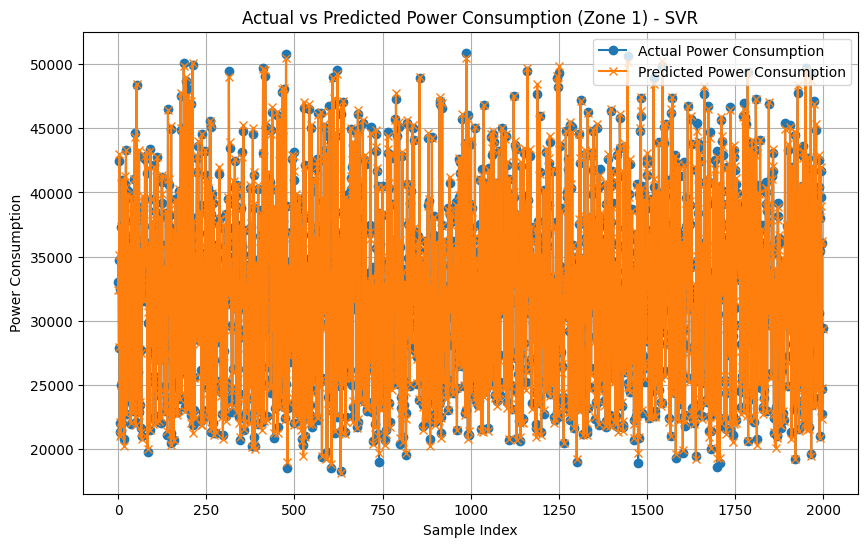

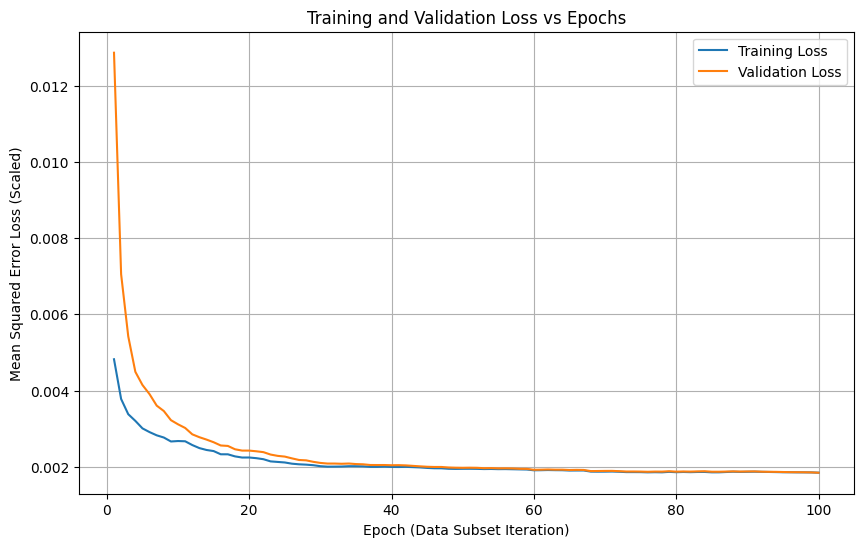

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Data inspection
print("Data Summary:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())

# Features (consistent with previous code)
features = ['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows', 'Hour', 'Day', 'Month','PowerConsumption_Zone1']
X = df[features]
y = df['PowerConsumption_Zone1']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Standardize target variable
y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Simulate epochs by incrementally increasing training data
n_epochs = 100
train_losses = []
val_losses = []
n_samples = len(X_train)
step_size = max(1, n_samples // n_epochs)  # Ensure at least 1 sample per step

# Initialize model
model = SVR(kernel='rbf', C=100, epsilon=0.1)

for epoch in range(n_epochs):
    # Use increasing subsets of training data
    end_idx = min((epoch + 1) * step_size, n_samples)
    X_train_subset = X_train[:end_idx]
    y_train_subset = y_train[:end_idx]

    # Train model on subset
    model.fit(X_train_subset, y_train_subset)

    # Compute training and validation loss
    y_pred_train = model.predict(X_train_subset)
    y_pred_val = model.predict(X_test)
    train_loss = mean_squared_error(y_train_subset, y_pred_train)
    val_loss = mean_squared_error(y_test, y_pred_val)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}/{n_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Final model training on full training data
model.fit(X_train, y_train)
y_pred_scaled = model.predict(X_test)

# Inverse transform for evaluation
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_orig = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Testing
mse = mean_squared_error(y_test_orig, y_pred)
r2 = r2_score(y_test_orig, y_pred)
print(f'Mean Squared Error: {mse:.2f}')
print(f'R² Score: {r2:.2f}')

# Plotting actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test_orig[:2000], label='Actual Power Consumption', marker='o')
plt.plot(y_pred[:2000], label='Predicted Power Consumption', marker='x')
plt.title('Actual vs Predicted Power Consumption (Zone 1) - SVR')
plt.xlabel('Sample Index')
plt.ylabel('Power Consumption')
plt.legend()
plt.grid(True)
plt.show()

# Plotting loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, n_epochs + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss vs Epochs')
plt.xlabel('Epoch (Data Subset Iteration)')
plt.ylabel('Mean Squared Error Loss (Scaled)')
plt.legend()
plt.grid(True)
plt.show()
